In [12]:
#importing required libraries
import numpy as np        # ndarrys for gridded data
import pandas as pd       # DataFrames for tabular data

In [13]:
#reading a .csv file as a DataFrame (petroleumflowdat.csv)
gas = pd.read_csv("gasProduction.csv")
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5337 entries, 0 to 5336
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time        5337 non-null   object 
 1   Production  5337 non-null   float64
dtypes: float64(1), object(1)
memory usage: 83.5+ KB


In [14]:
# we using this command for a table preview
gas.head()

,Time,Production
0,5/22/2004,10.7415
1,5/23/2004,23.6240
2,5/24/2004,24.2405
3,5/25/2004,25.1527
4,5/26/2004,24.2440


In [15]:
gas.tail()

,Time,Production
5332,12/27/2018,10.7386
5333,12/28/2018,10.7306
5334,12/29/2018,11.1873
5335,12/30/2018,10.7262
5336,12/31/2018,10.7001


In [16]:
# converting the date column to date format
gas['Time'] = pd.to_datetime(gas['Time'],format='%m/%d/%Y')
gas.set_index('Time',inplace=True)

In [17]:
gas.head()

,Production
Time,
2004-05-22,10.7415
2004-05-23,23.6240
2004-05-24,24.2405
2004-05-25,25.1527
2004-05-26,24.2440


In [18]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5337 entries, 2004-05-22 to 2018-12-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  5337 non-null   float64
dtypes: float64(1)
memory usage: 83.4 KB


In [19]:
gas.columns

Index(['Production'], dtype='object')

In [6]:
# check missing values
gas.isnull().sum()

Production    0
dtype: int64

The dataset is clean, no missing values.

In time series data points have a temporal nature in them i.e the time dimension adds an explicit ordering to our data points that should be preserved because they can provide additional/important information to the learning algorithms. Therefore before we apply traditional ML methods it is imperative we perform some preprocessing to make them applicable. 

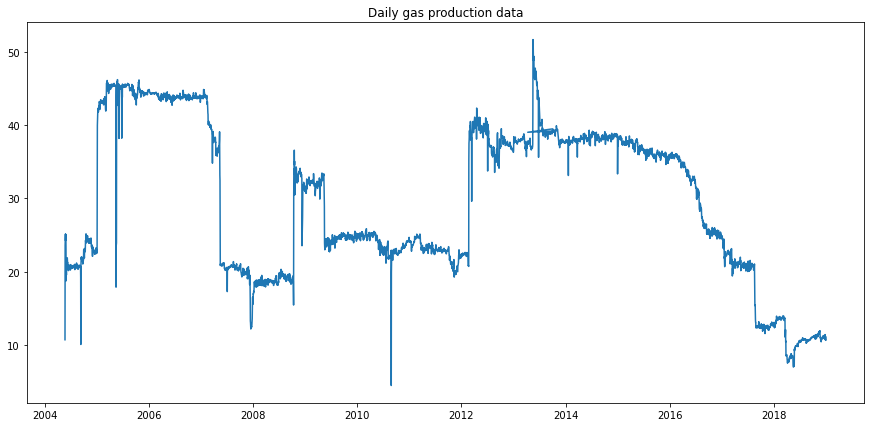

In [7]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters
plt.figure(figsize = (15, 7))
plt.plot(gas['Production'])
plt.title('Daily gas production data')
plt.show()

We now need to do some feature engineering to make the seris usable downstream using traditional supervised ML methods.
Generating lagged features and window statistics from them.
We will also add date & time features such as moth, year and day of the week.

In [20]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def autocorr_plots(y, lags=20, alpha=0.05):
    """
    Function to plot autocorrelations and partial autocorrelations

    y: Time series data
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """
    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))
    
    fig, ax = plt.subplots(ncols=2, figsize=(18, 6), sharey=True)
    
    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0], color='indigo')
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[0].set_title('Autocorrelation', fontsize=16)
    
    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle', color='indigo')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[1].set_title('Partial Autocorrelation', fontsize=16)
    
    return fig, ax

def adf_statistics(series):
    """
    Function to output Augmented Dickey-Fuller test for stationarity
    
    series: Time series of interest
    """
    result = adfuller(series.values)
    
    print('ADF Statistic: %.4f' % result[0])
    print('p-value: %.4f' % result[1])
    
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.4f' % (key, value))
    if result[1] < 0.0500:
        print("Null hypothesis of non-stationarity is rejected")
    else:
        print("Null hypothesis of non-stationarity is NOT rejected")



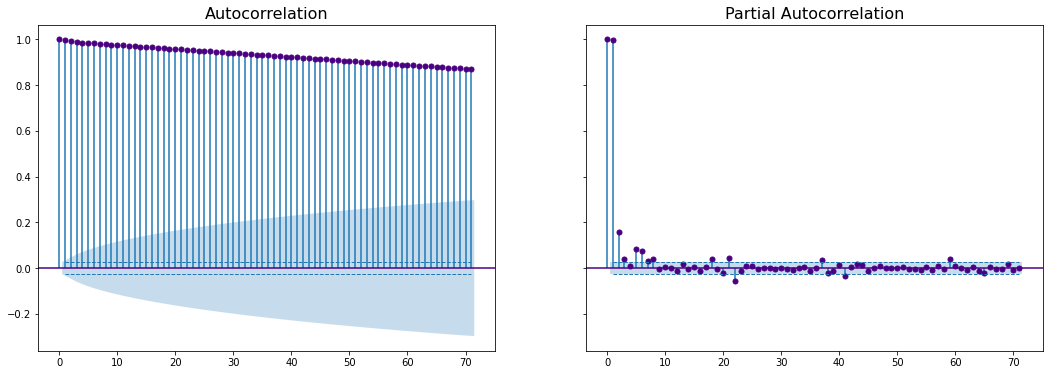

In [21]:
fig, ax = autocorr_plots(gas['Production'], lags= 71)

Here too we have a non stationary timeseries, we can see that it decays very slowly and there is no seasonality. Only a strong trend. Important as for some ML methods we will need to detrend before training/tuning.

In [55]:
import warnings

In [23]:
label_col = 'y'
data = pd.DataFrame(gas['Production'].copy())
data.columns = [label_col]
for i in range(1, 3):
    data['lag_{}'.format(i)] = data[label_col].shift(i)


data = data.dropna()
data.head()

,y,lag_1,lag_2
Time,,,
2004-05-24,24.2405,23.6240,10.7415
2004-05-25,25.1527,24.2405,23.6240
2004-05-26,24.2440,25.1527,24.2405
2004-05-27,25.1299,24.2440,25.1527
2004-05-28,24.9609,25.1299,24.2440


In [42]:
y = data[label_col].values
X = data.drop(label_col, axis = 1)
X = X.values

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [44]:
def timeseries_train_test_split(X, y, test_size):
    """Perform train-test split with respect to time series structure."""
    test_index = int(len(X) * (1 - test_size))
    X_train = X[:test_index]
    X_test = X[test_index:]
    y_train = y[:test_index]
    y_test = y[test_index:]
    return X_train, X_test, y_train, y_test

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score, cross_validate

In [46]:
import xgboost as xgb
from sklearn.svm import SVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

In [29]:
time_split_inner = TimeSeriesSplit(n_splits = 3)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [31]:
def plot_model_results1(X, y,model,search_params, test_size=0.3, plot_intervals=False, plot_anomalies=False):
    """
    - Plots modelled vs original values.
    - Prediction intervals (95% confidence interval).
    - Anomalies (points that resides outside the confidence interval).
    """

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size)

# we are using random forest here, feel free to swap this out
# with your favorite regression model
# model = RandomForestRegressor(max_depth=6, n_estimators=50)
    model1 = GridSearchCV (model, search_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                     n_jobs=-1, verbose=1)
    model1.fit(X_train, y_train)
    final_model = model1.best_estimator_
    prediction = final_model.predict(X_test)

    plt.figure(figsize=(15, 7))

    x = range(prediction.size)
    plt.plot(x, prediction, label='prediction', linewidth=2.0)
    plt.plot(x, y_test, label='actual', linewidth=2.0)
    if plot_intervals:
        timeseries_cv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_train, y_train, 
                             cv=timeseries_cv, scoring='neg_mean_absolute_error')
        mae = -1 * cv.mean()
        deviation = cv.std()

# hard-coded to be 95% confidence interval
        scale = 1.96
        margin_error = mae + scale * deviation
        lower = prediction - margin_error
        upper = prediction + margin_error

        fill_alpha = 0.2
        fill_color = '#66C2D7'
        plt.fill_between(x, lower, upper, color=fill_color, alpha=fill_alpha, label='95% CI')      

        if plot_anomalies:
            anomalies = np.array([np.nan] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, 'o', markersize=10, label='Anomalies')

    error = mean_absolute_percentage_error(prediction, y_test)
    error_MSE = mean_squared_error(prediction, y_test)
    error_r2 = mean_absolute_error(prediction, y_test)
    error_mae = r2_score(prediction, y_test)
    plt.title('Mean absolute percentage error {0:.2f}%'.format(error))
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True)
    print("The mean squared error is:", error_r2)
    print("The R 2 is:", error_MSE)
    print("The mean absolute error is:", error_mae)
    print("The root_mean square error is:", np.sqrt(error_MSE))
#print('The accuracy is:',accuracy)

    return model

# Random Forest

In [32]:
# Random forest Regressor
rf = RandomForestRegressor(n_estimators=400, min_samples_split=3, max_features='sqrt', random_state=8)

rf_params = {'n_estimators': range(300, 500, 25),
             'min_samples_split': [2, 3, 4, 5, 6, 7],
             'max_features': ['log2', 'sqrt']}

Fitting 3 folds for each of 96 candidates, totalling 288 fits
The mean squared error is: 1.0860851022923417
The R 2 is: 3.989972462671579
The mean absolute error is: 0.9586147394976056
The root_mean square error is: 1.9974915425782356


RandomForestRegressor(max_features='sqrt', min_samples_split=3,
                      n_estimators=400, random_state=8)

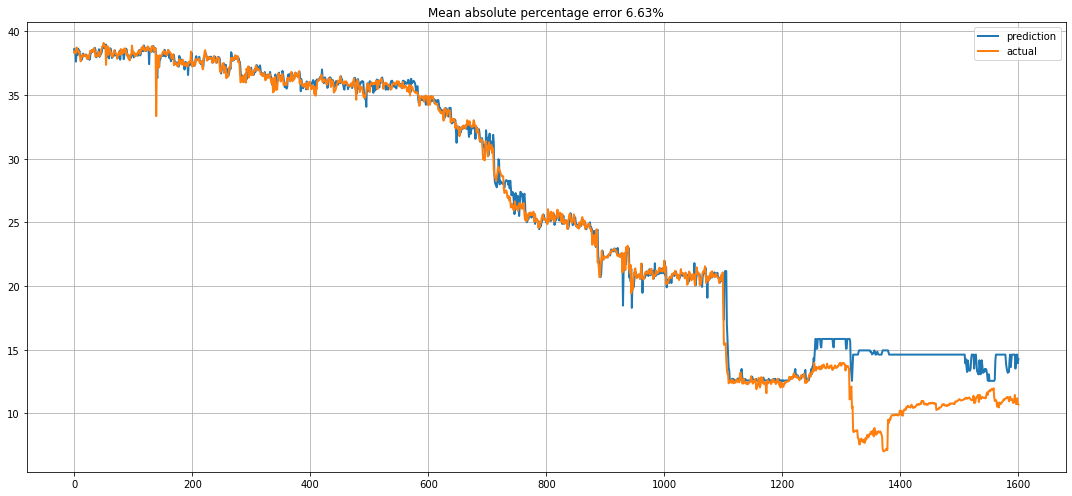

In [33]:
plot_model_results1(X,y, rf, rf_params)

# XGBOOST

In [34]:
xgb = xgb.XGBRegressor(n_estimators=100, gamma=200, eta=0.1, subsample=1, objective='reg:squarederror', 
                       random_state=8)

xgb_params = {'n_estimators': range(70, 140, 10),
              'subsample': [0.5, 0.75, 1],
              'eta': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
              'gamma': range(150, 310, 10)}

Fitting 3 folds for each of 2016 candidates, totalling 6048 fits
The mean squared error is: 1.3979010737059936
The R 2 is: 5.29305347128611
The mean absolute error is: 0.9404522203919421
The root_mean square error is: 2.3006637023446324


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None, gamma=200,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=8,
             reg_alpha=None, ...)

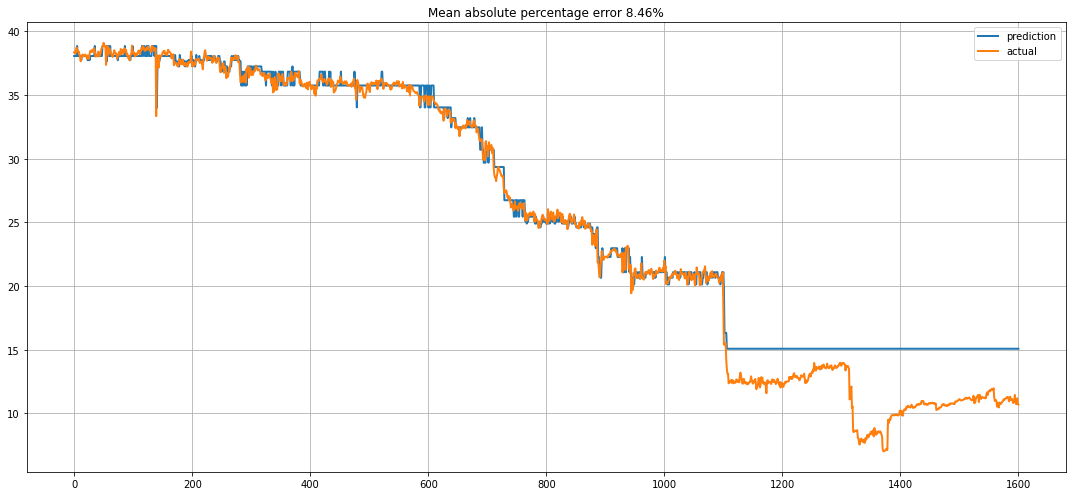

In [35]:
plot_model_results1(X,y, xgb, xgb_params)

# LASSO REGRESSION

In [36]:
# Lasso Regression
lasso = Lasso(fit_intercept=1, alpha=0.05, max_iter=10000, random_state=8)

las_params = {'fit_intercept': [1, 0],
              'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1]}

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The mean squared error is: 0.21377731033022718
The R 2 is: 0.1361007746341509
The mean absolute error is: 0.9988513967395973
The root_mean square error is: 0.3689183847874092


Lasso(alpha=0.05, fit_intercept=1, max_iter=10000, random_state=8)

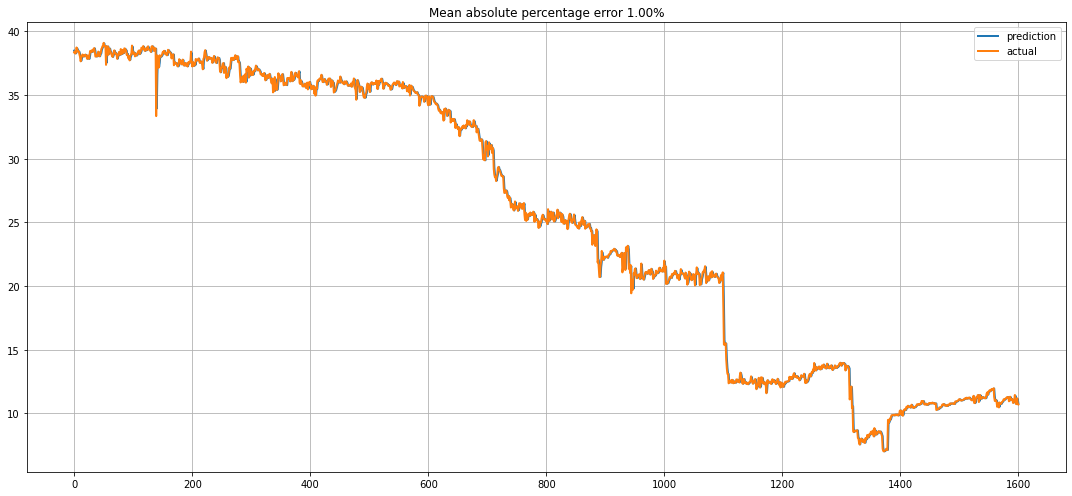

In [37]:
plot_model_results1(X,y, lasso, las_params)

## RNN/LSTM

In [38]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [59]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [60]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5337 entries, 2004-05-22 to 2018-12-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  5337 non-null   float64
dtypes: float64(1)
memory usage: 83.4 KB


In [64]:
values1 = gas.values
values2 = values1.astype('float32')
# normalize features 
scaler = MinMaxScaler(feature_range=(0,1))
# specify the number of lags
scaled = scaler.fit_transform(values2)


In [65]:
reframed = series_to_supervised(scaled, 1, 1)

In [66]:
# get values
values1 = gas.values
values2 = values1.astype('float32')
# normalize features 
scaler = MinMaxScaler(feature_range=(0,1))
# specify the number of lags
scaled = scaler.fit_transform(values2)
reframed = series_to_supervised(scaled, 1, 1)
n = 2
# test train split
n_train = int(gas.shape[0]*0.70)
values3 = reframed.values
train = values3[:n_train, :]
test = values3[n_train:, :]
# get the inputs and the out puts
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# Reshape
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3735, 1, 1) (3735,) (1601, 1, 1) (1601,)


In [74]:
pip install tensorflow

In [75]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Epoch 1/50
52/52 - 7s - loss: 0.4590 - val_loss: 0.2307 - 7s/epoch - 129ms/step
Epoch 2/50
52/52 - 0s - loss: 0.1801 - val_loss: 0.1403 - 334ms/epoch - 6ms/step
Epoch 3/50
52/52 - 0s - loss: 0.1381 - val_loss: 0.1264 - 306ms/epoch - 6ms/step
Epoch 4/50
52/52 - 0s - loss: 0.1236 - val_loss: 0.1138 - 332ms/epoch - 6ms/step
Epoch 5/50
52/52 - 0s - loss: 0.1111 - val_loss: 0.1020 - 343ms/epoch - 7ms/step
Epoch 6/50
52/52 - 0s - loss: 0.1001 - val_loss: 0.0903 - 324ms/epoch - 6ms/step
Epoch 7/50
52/52 - 0s - loss: 0.0881 - val_loss: 0.0788 - 330ms/epoch - 6ms/step
Epoch 8/50
52/52 - 0s - loss: 0.0795 - val_loss: 0.0650 - 314ms/epoch - 6ms/step
Epoch 9/50
52/52 - 0s - loss: 0.0653 - val_loss: 0.0595 - 364ms/epoch - 7ms/step
Epoch 10/50
52/52 - 0s - loss: 0.0591 - val_loss: 0.0403 - 340ms/epoch - 7ms/step
Epoch 11/50
52/52 - 0s - loss: 0.0239 - val_loss: 0.0456 - 332ms/epoch - 6ms/step
Epoch 12/50
52/52 - 0s - loss: 0.0181 - val_loss: 0.0360 - 357ms/epoch - 7ms/step
Epoch 13/50
52/52 - 0s - l

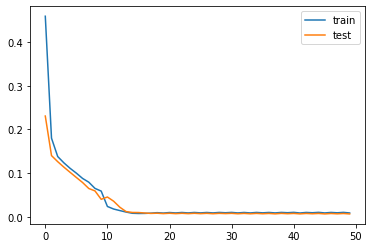

In [76]:
# network
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [77]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.459


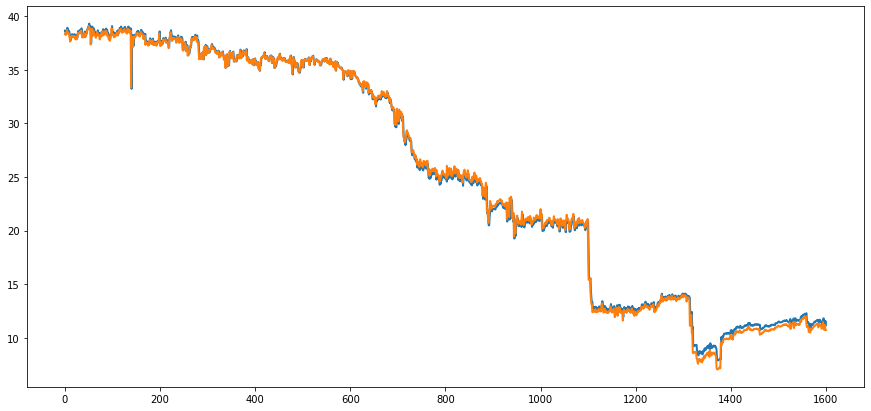

In [78]:
plt.figure(figsize=(15, 7))

x = range(inv_yhat.size)
plt.plot(x,inv_yhat, label='prediction', linewidth=2.0)
plt.plot(x, inv_y, label='actual', linewidth=2.0)
plt.show()

In [79]:
error_MSE = mean_squared_error(inv_y,  inv_yhat)
error_r2 = mean_absolute_error(inv_y,  inv_yhat)
error_mae = r2_score(inv_y, inv_yhat)

In [80]:
print("The mean squared error is:", error_r2)
print("The R 2 is:", error_MSE)
print("The mean absolute error is:", error_mae)
print("The root_mean square error is:", np.sqrt(error_MSE))

The mean squared error is: 0.32554892
The R 2 is: 0.2108577
The mean absolute error is: 0.9982221987833627
The root_mean square error is: 0.45919245
